In [ ]:
# necessary for DenodoConnection
#%pip install psycopg2-binary
#%pip install shap

In [2]:
# import packages
import os
import sys

import pandas as pd, numpy as np
import json
import argparse
import os

import pickle
import warnings

# need to add dme_sagemaker to path to load in libraries
sys.path.append("/root/dme_sagemaker/dme_sagemaker")

from libs.denodo.denodo_connection import DenodoConnection
import libs.performance_lib.performance_sql_recipes as performance_sql_recipes
from libs.helper.parameters_helper import ParametersHelper

from libs.performance_lib import predictive_advancement_lib
from libs.performance_lib import performance_validation_lib

import matplotlib.pyplot as plt
import boto3

from sklearn.model_selection import train_test_split

ENVIRONMENT name from config_vars: uat
DME_PROJECT name from config_vars: None


In [3]:
DKU_DST_ap_data_sector = 'CORN_BRAZIL_SUMMER'
DKU_DST_analysis_type = 'GenoPred'
input_years = ['2019','2020','2021','2022']
bucket = 'us.com.syngenta.ap.nonprod'

# convert each entry in input years to an integer since they come in as str.
if isinstance(input_years, list):
    input_years_as_int = [int(val) for val in input_years]
else:
    input_years_as_int = [int(input_years)]

In [4]:
# when testing, we read directly from S3, bucket is provided as a separate input to function, don't include in input args. 
input_args = [
    '--s3_input_pred_adv_data_folder', 'uat/dme/performance/compute_pred_adv_data_collected/data/'
]

parser = argparse.ArgumentParser(description='app inputs and outputs')
parser.add_argument('--s3_input_pred_adv_data_folder', type=str,
                    help='s3 input pred_adv_data folder', required=True)
args = parser.parse_args(input_args)

In [5]:
potential_fnames = predictive_advancement_lib.load_potential_fnames(prefix='new_')

df_input_piv = predictive_advancement_lib.load_and_preprocess_all_inputs_ml(
    args,
    DKU_DST_ap_data_sector,
    DKU_DST_analysis_type,
    potential_fnames,
    years_to_load=input_years,
    read_from_s3=1,
    bucket=bucket
)

/opt/conda/lib/python3.7/site-packages/boto3/compat.py:82: PythonDeprecationWarning: Boto3 will no longer support Python 3.7 starting December 13, 2023. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.8 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  # Remove the CWD from sys.path while we load stuff.


(50128, 44)
(145042, 9)
(48021, 47)
(118128, 9)
(22488, 54)
(4246, 21)
(11, 4)
(77136, 9)
(20945, 53)
(7579, 21)
(187155, 25)
(35, 4)
(61583, 9)


In [6]:
df_input_piv[df_input_piv['material_type_simple'] != 'entry'][['entry_identifier','current_stage','analysis_year']].groupby(by=['current_stage','analysis_year']).count()

entry_identifier
current_stage analysis_year                  
1.0           2019                      21766
              2020                      18960
              2021                       4319
              2022                       3584
3.0           2019                       1925
              2020                       1747
              2021                        885
              2022                       2220
4.0           2019                        637
              2020                       1835
              2021                       3201
              2022                       2368
5.0           2019                        315
              2020                        436
              2021                       1073
              2022                        703
6.0           2019                         58
              2020                        148
              2021                        144
              2022                        159
7.0           2019                         36
              2020                        140
              2021                        288
              2022                        160

In [61]:
for col in df_input_piv.columns:
    print(col, df_input_piv[col][(df_input_piv['current_stage'] == 4)].count())

ap_data_sector 18796
analysis_year 18796
entry_identifier 18796
material_type_simple 18796
chkfl_ERHTN 17386
chkfl_GMSTP 17381
chkfl_GWTPN 17349
chkfl_HAVPN 2226
chkfl_LRTLR 15338
chkfl_PLHTN 17407
chkfl_STD_N 7413
chkfl_STD_P 2227
chkfl_STKLR 15384
chkfl_TWSMN 13069
chkfl_YGHMN 17347
chkfl_YGMRN 17347
chkfl_YGSMN 17347
cpifl 55
result_ERHTN 17386
result_GMSTP 17381
result_GWTPN 17349
result_HAVPN 2226
result_LRTLR 15338
result_PLHTN 17407
result_STD_N 7413
result_STD_P 2227
result_STKLR 15384
result_TWSMN 13069
result_YGHMN 17347
result_YGMRN 17347
result_YGSMN 17347
result_diff_ERHTN 17386
result_diff_GMSTP 17381
result_diff_GWTPN 17349
result_diff_HAVPN 2226
result_diff_LRTLR 15338
result_diff_PLHTN 17407
result_diff_STD_N 7413
result_diff_STD_P 2227
result_diff_STKLR 15384
result_diff_TWSMN 13069
result_diff_YGHMN 17347
result_diff_YGMRN 17347
result_diff_YGSMN 17347
current_stage 18796
next_stage 18796
prev_stage 9490
third_stage 18796
was_adv 18796
was_adv_next 18796
decision_gro

In [9]:
df_input_piv[['was_adv','current_stage','analysis_year']].groupby(by=['current_stage','analysis_year']).sum()

was_adv
current_stage analysis_year         
1.0           2019             938.0
              2020             623.0
              2021             805.0
              2022             463.0
3.0           2019             326.0
              2020             593.0
              2021             152.0
              2022             105.0
4.0           2019             111.0
              2020             350.0
              2021             522.0
              2022             224.0
5.0           2019              17.0
              2020              58.0
              2021             119.0
              2022               5.0
6.0           2019               0.0
              2020               0.0
              2021               0.0
              2022               0.0
7.0           2019               0.0
              2020               0.0
              2021               0.0
              2022               0.0

In [60]:
traits = ['ERHTN','GMSTP','LRTLR','PLHTN','SDSWN','STKLR','TWSMN','YGSMN','YGMRN']

df_piv = df_input_piv[(df_input_piv['material_type_simple'] != 'entry') &
                      (df_input_piv['current_stage'] >= 4) &
                      (df_input_piv['current_stage'] <= 4)] 

df_piv[['was_adv'] + ['result_'+trait for trait in traits]].corr()

,was_adv,result_ERHTN,result_GMSTP,result_LRTLR,result_PLHTN,result_SDSWN,result_STKLR,result_TWSMN,result_YGSMN,result_YGMRN
was_adv,1.000000,-0.067577,-0.128915,0.003400,-0.074230,0.061463,-0.023336,0.037446,-0.103023,-0.019877
result_ERHTN,-0.067577,1.000000,0.271803,0.052440,0.903274,-0.087900,0.154194,0.011452,0.347920,0.270243
result_GMSTP,-0.128915,0.271803,1.000000,-0.009887,0.165848,0.107077,-0.137138,-0.217690,0.632809,0.007157
result_LRTLR,0.003400,0.052440,-0.009887,1.000000,0.038264,0.014853,0.041915,-0.016213,-0.025536,-0.013245
result_PLHTN,-0.074230,0.903274,0.165848,0.038264,1.000000,-0.126903,0.173819,0.090771,0.453398,0.494352
result_SDSWN,0.061463,-0.087900,0.107077,0.014853,-0.126903,1.000000,-0.008143,-0.154960,0.082877,-0.066393
result_STKLR,-0.023336,0.154194,-0.137138,0.041915,0.173819,-0.008143,1.000000,-0.000248,-0.362563,-0.269786
result_TWSMN,0.037446,0.011452,-0.217690,-0.016213,0.090771,-0.154960,-0.000248,1.000000,-0.111140,0.143048
result_YGSMN,-0.103023,0.347920,0.632809,-0.025536,0.453398,0.082877,-0.362563,-0.111140,1.000000,0.755508
result_YGMRN,-0.019877,0.270243,0.007157,-0.013245,0.494352,-0.066393,-0.269786,0.143048,0.755508,1.000000


In [68]:
traits = ['ERHTN','GMSTP','LRTLR','PLHTN','SDSWN','STKLR','TWSMN','YGSMN','YGMRN']

df_piv = df_input_piv[(df_input_piv['material_type_simple'] != 'entry') &
                      (df_input_piv['current_stage'] >= 4) &
                      (df_input_piv['current_stage'] <= 4)] 

df_piv[['was_adv'] + ['result_diff_'+trait for trait in traits]].corr()

,was_adv,result_diff_ERHTN,result_diff_GMSTP,result_diff_LRTLR,result_diff_PLHTN,result_diff_SDSWN,result_diff_STKLR,result_diff_TWSMN,result_diff_YGSMN,result_diff_YGMRN
was_adv,1.000000,0.066911,-0.090281,-0.009775,0.074698,0.035663,-0.033451,-0.034101,0.096460,0.093817
result_diff_ERHTN,0.066911,1.000000,-0.078740,0.059283,0.758215,0.167143,0.090007,-0.051771,0.200816,0.159577
result_diff_GMSTP,-0.090281,-0.078740,1.000000,0.043763,-0.122527,-0.146657,-0.027289,0.079557,-0.004493,-0.477673
result_diff_LRTLR,-0.009775,0.059283,0.043763,1.000000,0.055730,0.003717,0.044354,-0.002104,-0.101869,-0.081584
result_diff_PLHTN,0.074698,0.758215,-0.122527,0.055730,1.000000,0.149002,0.080610,-0.033733,0.250096,0.207970
result_diff_SDSWN,0.035663,0.167143,-0.146657,0.003717,0.149002,1.000000,0.034573,0.065006,0.040905,0.131555
result_diff_STKLR,-0.033451,0.090007,-0.027289,0.044354,0.080610,0.034573,1.000000,-0.013363,-0.277903,-0.143921
result_diff_TWSMN,-0.034101,-0.051771,0.079557,-0.002104,-0.033733,0.065006,-0.013363,1.000000,-0.043867,-0.069285
result_diff_YGSMN,0.096460,0.200816,-0.004493,-0.101869,0.250096,0.040905,-0.277903,-0.043867,1.000000,0.554685
result_diff_YGMRN,0.093817,0.159577,-0.477673,-0.081584,0.207970,0.131555,-0.143921,-0.069285,0.554685,1.000000


In [58]:
traits = ['COSTR','ERHTN','GMSTP','LFSPR','LRTLR','PLHTN','STKLR','YGSMN']

df_piv = df_input_piv[(df_input_piv['material_type_simple'] != 'entry') &
                      (df_input_piv['current_stage'] >= 4) &
                      (df_input_piv['current_stage'] <= 4)] 

df_piv[['was_adv'] + [trait+'_prediction' for trait in traits]].corr()

,was_adv,COSTR_prediction,ERHTN_prediction,GMSTP_prediction,LFSPR_prediction,LRTLR_prediction,PLHTN_prediction,STKLR_prediction,YGSMN_prediction
was_adv,1.000000,0.045189,-0.016942,-0.167975,0.082221,0.070482,-0.000618,0.021025,0.007842
COSTR_prediction,0.045189,1.000000,-0.529959,-0.541903,0.764675,0.228544,-0.276170,0.194152,-0.351230
ERHTN_prediction,-0.016942,-0.529959,1.000000,0.508540,-0.594351,-0.250718,0.825680,-0.353711,0.577541
GMSTP_prediction,-0.167975,-0.541903,0.508540,1.000000,-0.423795,-0.417089,0.376559,-0.233775,0.585151
LFSPR_prediction,0.082221,0.764675,-0.594351,-0.423795,1.000000,0.174320,-0.412968,0.271981,-0.324257
LRTLR_prediction,0.070482,0.228544,-0.250718,-0.417089,0.174320,1.000000,-0.142616,-0.097460,-0.323576
PLHTN_prediction,-0.000618,-0.276170,0.825680,0.376559,-0.412968,-0.142616,1.000000,-0.258264,0.564940
STKLR_prediction,0.021025,0.194152,-0.353711,-0.233775,0.271981,-0.097460,-0.258264,1.000000,-0.248028
YGSMN_prediction,0.007842,-0.351230,0.577541,0.585151,-0.324257,-0.323576,0.564940,-0.248028,1.000000


In [69]:
def process_harvt(row_in):
    if isinstance(row_in,str):
        return 'drop' in row_in.lower()
    else:
        return False

#### FILTER TO DESIRED DATA for training
# filter materials: want stages 1-4, material type is parent for corn
# want stages 2-5, material type is entry for soy

df_input_piv['harvt_drop'] = df_input_piv['harvt'].apply(process_harvt)
df_piv = df_input_piv[(df_input_piv['material_type_simple'] != 'entry') &
                      (df_input_piv['current_stage'] >= 4) &
                      (df_input_piv['current_stage'] <= 4) &
                      (df_input_piv['harvt_drop'] == False)]

#### preprocess text traits for corn
if 'decision_group' not in df_piv.columns:
    df_piv['decision_group'] = df_piv['current_stage']

In [70]:
### train model.
grouping_cols = predictive_advancement_lib.get_grouping_cols_per_sector(analysis_sector=DKU_DST_ap_data_sector)
df_piv_grouped = df_piv.groupby(by=grouping_cols)

In [71]:
def stratified_train_test_split(df_in, out_col):
    df_tr_list = []
    df_te_list = []
    
    for out_val in pd.unique(df_in[out_col]):
        df_in_val = df_in[df_in[out_col] == out_val]
        df_tr_val, df_te_val = train_test_split(df_in_val, test_size=0.2)
        df_tr_list.append(df_tr_val)
        df_te_list.append(df_te_val)
        
    df_tr = pd.concat(df_tr_list,axis=0)
    df_te = pd.concat(df_te_list,axis=0)
    
    return df_tr, df_te


In [83]:
for index, df_use in df_piv_grouped:  # build model per unique combination of grouping_cols; stage currently
    # get model parameters for this sector and stage
    args = []
    # model parameters
    # extract inputs from args
    # get input and output column names
    
    if index[1] == 1:
        extra_traits = []
        numeric_diff_traits = ['YGSMN'] #'YGSMN-PLHTN-ERHTN-GMSTP', plhtn and erhtn are sparse
        numeric_raw_traits = ['GMSTP','TWSMN','LRTLR','STKLR','SDSWN']
        text_traits = [] #'pltqt','notet' at some point?
        
        preproc_steps = []
    elif index[1] == 3:
        extra_traits = []
        numeric_diff_traits = ['SDSWN','YGSMN-PLHTN-ERHTN-GMSTP'] #'YGSMN-PLHTN-ERHTN-GMSTP'
        numeric_raw_traits = ['GMSTP','TWSMN','LRTLR','STKLR','ERHTN','PLHTN']
        prediction_traits = []
        text_traits = [] #'pltqt','notet' at some point?
        
        preproc_steps = ['subtract corr']
        
    elif index[1] == 4:
        extra_traits = []
        numeric_diff_traits = ['SDSWN','YGSMN'] #'YGSMN-PLHTN-ERHTN-GMSTP'
        numeric_raw_traits = ['GMSTP','TWSMN','LRTLR','STKLR','ERHTN','PLHTN']
        prediction_traits = []
        text_traits = [] #'pltqt','notet' at some point?
        
        preproc_steps = []
        
    mdl_in_cols = []
    mdl_in_cols.extend(['result_diff_' + trait for trait in numeric_diff_traits])
    mdl_in_cols.extend(['result_' + trait for trait in numeric_raw_traits])
    mdl_in_cols.extend([trait+'_prediction' for trait in prediction_traits])

    cols_to_norm = []
    mdl_out_col = 'was_adv'

    # get parameters for xgboost models
    xgb_params_class = predictive_advancement_lib.XGBoostModelParameters(
        max_depth=5,
        reg_lambda=100,
        subsample=0.2,
        learning_rate=0.005,
        n_estimators=500
    )

    # if the output var is not a boolean, this causes problems. check
    if not isinstance(df_use[mdl_out_col].dtype, bool):
        df_use[mdl_out_col] = df_use[mdl_out_col].astype(bool)

    preproc_class = predictive_advancement_lib.PredAdvPreprocessor(
        preprocess_steps=preproc_steps,
        corr_traits=[
            [['PLHTN','ERHTN','GMSTP'],['YGSMN']]
        ],
        corr_score_col='result_diff'
        
    )    

    mdl_class = predictive_advancement_lib.PredAdvMdl(
        params=xgb_params_class.params,
        in_cols=mdl_in_cols,
        out_col=mdl_out_col,
        weight_by_col=False
    )
  
    df_tr, df_te = stratified_train_test_split(df_use, out_col='was_adv')
    df_tr_proc = preproc_class.train_preprocessing(df_tr)
    
    # update mdl in cols based on preprocessing steps
    if 'process rm' in preproc_class.preprocess_steps:
        mdl_class.in_cols.append('rm_estimate_proc')
        # if there are dummy vars added to df_use_proc due to processing text traits, add to mdl in cols
    if 'process text traits' in preproc_class.preprocess_steps:
        new_cols = list(set(df_tr_proc.columns).difference(set(df_use.columns)))
        if 'process rm' in preproc_class.preprocess_steps:
            mdl_class.in_cols.remove('rm_estimate_proc')
        mdl_class.in_cols.extend(new_cols)
    if 'get qualifiers' in preproc_class.preprocess_steps:
        cols_to_append = df_tr_proc.columns[['qualifiers_' in col for col in df_tr_proc.columns]]
        mdl_in_cols.extend(cols_to_append)

        
    # make sure each column in mdl_in col is also in the dataframe
    mdl_in_cols_use = mdl_in_cols.copy()
    for col in mdl_in_cols:
        if col not in df_use.columns:
            mdl_in_cols_use.remove(col)
    mdl_in_cols = mdl_in_cols_use
        
    mdl_class.train_mdl(df_tr_proc);
    df_tr_proc['recommendation_score'] = mdl_class.predict_proba(df_tr_proc)
    df_input_stats = performance_validation_lib.compute_input_statistics(
        df_in=df_tr_proc,
        in_cols=mdl_class.in_cols
    )
    # get predictions, print metrics on training dataset (not representative of performance).
    print("Train:",index,df_tr_proc.shape,mdl_class.score(df_tr_proc, df_tr_proc[mdl_out_col].values))
    
    # some validation metrics:    
    df_te_proc = preproc_class.train_preprocessing(df_te)
    print("Test",index,df_te_proc.shape,mdl_class.score(df_te_proc, df_te_proc[mdl_out_col].values))

Mean of empty slice
All-NaN slice encountered
Degrees of freedom <= 0 for slice.
All-NaN slice encountered
All-NaN slice encountered
All-NaN slice encountered


Train: ('CORN_BRAZIL_SUMMER', 4.0) (6432, 102) (0.7645719489981786, array([[0.79303279, 0.20696721],
       [0.26388889, 0.73611111]]), 0.8449315694729053, 0.38336347197106685)
Test ('CORN_BRAZIL_SUMMER', 4.0) (1609, 101) (0.6771544368600683, array([[0.79180887, 0.20819113],
       [0.4375    , 0.5625    ]]), 0.7404484262419415, 0.3056603773584906)


Exact explainer: 1001it [04:10,  3.99it/s]                          


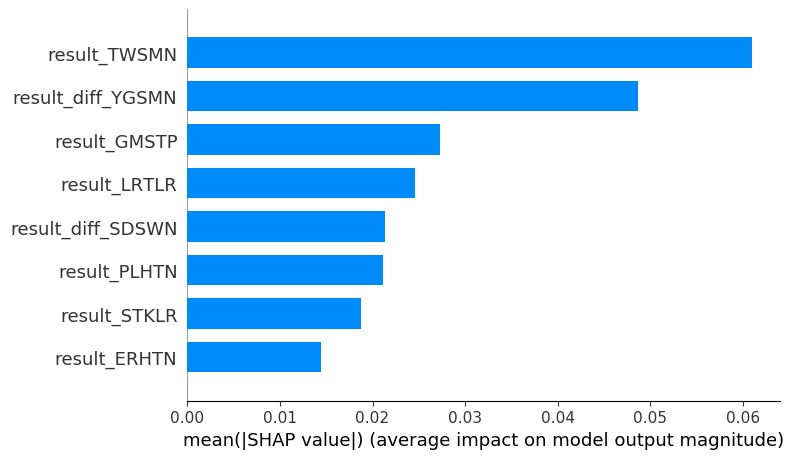

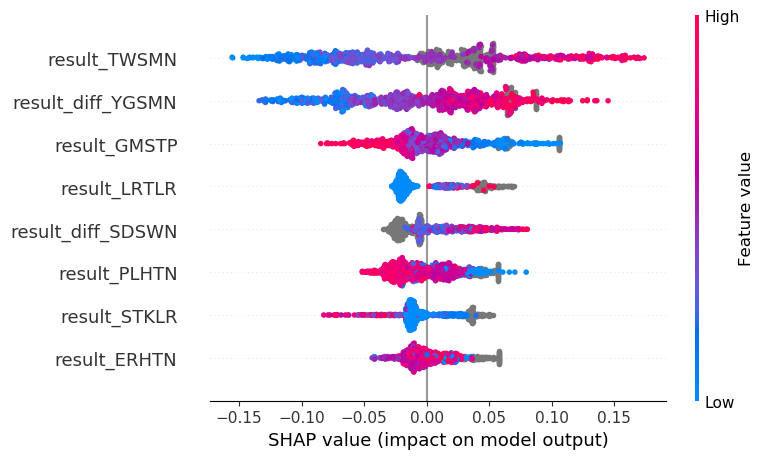

In [84]:
#shap code for new class method
# get and plot shapley values after training a model
do_shap = 1
if do_shap == 1:
    import shap
    x = df_te_proc[mdl_class.in_cols].values.astype(float)
    shap_input = shap.utils.sample(x, np.minimum(x.shape[0],1000))
    explainer = shap.Explainer(mdl_class.mdl.predict_proba, shap_input)
    shap_values = explainer(shap_input)
    shap_values = shap_values[:,:,1]

    shap.summary_plot(shap_values, feature_names=mdl_class.in_cols,\
                     plot_type='bar')

    shap.summary_plot(shap_values, feature_names=mdl_class.in_cols,\
                     plot_type='dot')

#for idx in range(len(mdl_class.in_cols)):
#    notnan_mask = np.isnan(shap_input[:,idx])==False
#    if np.sum(notnan_mask) > 10:
#        shap.plots.partial_dependence(idx,mdl_class.mdl.predict,shap_input[notnan_mask,:],ice=False,feature_names=mdl_class.in_cols)

# some useful shapley/interpolation related code
#plt.plot(shap_values[:,0].data, shap_values[:,0].values,'.')
#shap.plots.scatter(shap_values[:,5])

In [85]:
# make sure advancement columns are boolean
df_input = df_te_proc.copy()
df_input['recommendation_score'] = mdl_class.predict_proba(df_input)
if 'was_adv' in df_input.columns:
    df_input['was_adv'] = df_input['was_adv'].astype(bool)
if 'was_adv_next' in df_input.columns:
    df_input['was_adv_next'] = df_input['was_adv_next'].astype(bool)

# set trait column and yield column based on data sector
trait_prefix = 'result_' # this gets both result_ and result_diff cols
yield_col = 'result_diff_YGSMN' #'result_diff_YGSMN-PLHTN-ERHTN-GMSTP'

# compute metrics for each stage
adv_metrics_all = []
trait_metrics_all = []

for stg in pd.unique(df_input['current_stage']):
    df_use = df_input[df_input['current_stage'] == stg]
    df_use['random_nums'] = np.random.rand(df_use.shape[0], 1)
    adv_metrics, trait_metrics = performance_validation_lib.compute_model_metrics(
        df_use,
        compute_advancement_metrics=True,
        yield_col=yield_col,
        trait_prefix=trait_prefix
    )
    adv_metrics['stage'] = stg
    trait_metrics['stage'] = stg

    adv_metrics_all.append(adv_metrics)
    trait_metrics_all.append(trait_metrics)

# join across stages
df_adv_metrics = pd.concat(adv_metrics_all,axis=0)
df_trait_metrics = pd.concat(trait_metrics_all,axis=0)

invalid value encountered in true_divide
invalid value encountered in long_scalars
All-NaN slice encountered
All-NaN slice encountered
Mean of empty slice
Mean of empty slice
Mean of empty slice
Degrees of freedom <= 0 for slice.


In [86]:
np.sum(df_te_proc['was_adv'])/df_te_proc.shape[0]

0.08949658172778123

In [87]:
df_adv_metrics[df_adv_metrics['decision_group'] == 'all']

,mdl,decision_group,metric,value,stage
624,ML,all,AUC_PR_adv,0.240829,4.0
625,ML,all,AUC_PR_notadv,0.960578,4.0
626,ML,all,TN,1355.000000,4.0
627,ML,all,FP,110.000000,4.0
628,ML,all,FN,110.000000,4.0
629,ML,all,TP,34.000000,4.0
630,ML,all,n,1609.000000,4.0
631,ML,all,perc_adv_in_bottom_75perc,0.416667,4.0
632,yield,all,AUC_PR_adv,0.123108,4.0
633,yield,all,AUC_PR_notadv,0.928848,4.0
